In [1]:
import torch
import InternVideo
import pickle
import os
from glob import glob
from tqdm import tqdm

train_collision_index_path = "/mnt/NAS/data/ruixuan/data/processed_WTS/train_collision_index.pkl"
train_overhead_camera_path = "/mnt/NAS/data/ruixuan/data/processed_WTS/train_overhead_camera.pkl"
train_info_path = "/mnt/NAS/data/ruixuan/data/processed_WTS/WTS_processed_scenario_data_train.pickle"
train_normal_info_path = "/mnt/NAS/data/ruixuan/data/processed_WTS/WTS_processed_scenario_data_train_normal_trimmed.pickle"

with open(train_collision_index_path, 'rb') as f:
    train_collision_index = pickle.load(f)

with open(train_overhead_camera_path, 'rb') as f:
    train_overhead_camera = pickle.load(f)

with open(train_info_path, 'rb') as f:
    train_info = pickle.load(f)

with open(train_normal_info_path, 'rb') as f:
    train_normal_info = pickle.load(f)

In [2]:
WTS_TRAIN_PATH = "/mnt/NAS/data/ruixuan/data/olivia/videos/train"
pattern = "2023*"
search_pattern = os.path.join(WTS_TRAIN_PATH, pattern)
subfolders = glob(search_pattern)

# Extract the subfolder names
subfolder_names = [os.path.basename(subfolder) for subfolder in subfolders]
sorted_subfolders = sorted(subfolder_names, key=lambda x: [int(s) if s.isdigit() else s for s in x.split('_')])

In [4]:
device = torch.device("cuda:1")
model = InternVideo.load_model("./models/InternVideo-MM-L-14.ckpt").to(device)
text_cand = ["a vehicle has potential interaction with another pedestrian and causes abrupt change of pedestrian's behavior", "a vehicle is passing a pedestrian on the road without affecting pedestrian's movement"]
text = InternVideo.tokenize(
    text_cand
).to(device)

with torch.no_grad():
    text_features, attention = model.encode_text(text)
    text_features = torch.nn.functional.normalize(text_features, dim=1)

encoded_video_features = {}
encoded_text_probability = {}

for idx, scenario in tqdm(enumerate(sorted_subfolders)):
    
    assert scenario in train_overhead_camera[idx], "Scenario not found in overhead camera data"
    camera_view = train_overhead_camera[idx]
    video_path = train_info[scenario]['clipped_video_paths']['overhead_view'][camera_view+'.mp4']['4']
    video = InternVideo.load_video(video_path).to(device)

    with torch.no_grad():
        
        video_features = model.encode_video(video.unsqueeze(0))
        video_features = torch.nn.functional.normalize(video_features, dim=1)
        t = model.logit_scale.exp()
        probs = (video_features @ text_features.T * t).softmax(dim=-1).cpu().numpy()

    scenario_label = train_collision_index[idx]

    encoded_video_features[scenario] = video_features.squeeze(0).cpu().numpy()
    encoded_text_probability[scenario] = probs[0]

97it [00:45,  2.14it/s]


In [5]:
WTS_TRAIN_PATH = "/mnt/NAS/data/ruixuan/data/olivia/videos/train/normal_trimmed"
pattern = "2023*"
search_pattern = os.path.join(WTS_TRAIN_PATH, pattern)
subfolders = glob(search_pattern)

# Extract the subfolder names
subfolder_names = [os.path.basename(subfolder) for subfolder in subfolders]
sorted_subfolders = sorted(subfolder_names, key=lambda x: [int(s) if s.isdigit() else s for s in x.split('_')])

In [5]:
encoded_video_features_normal = {}
encoded_text_probability_normal = {}

for idx, scenario in tqdm(enumerate(sorted_subfolders)):
    
    video_path = next(iter(train_normal_info[scenario]['clipped_video_paths']['overhead_view'].values()))['4']
    video = InternVideo.load_video(video_path).to(device)

    with torch.no_grad():
        video_features = model.encode_video(video.unsqueeze(0))
        video_features = torch.nn.functional.normalize(video_features, dim=1).squeeze(0).cpu().numpy()

    encoded_video_features_normal[scenario] = video_features

70it [00:24,  2.83it/s]


In [9]:
with open('encoded_video_features.pickle', 'wb') as file:
    pickle.dump(encoded_video_features, file)

with open('encoded_video_features_normal.pickle', 'wb') as file:
    pickle.dump(encoded_video_features_normal, file)

In [43]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_train = np.array(list(encoded_video_features.values()))
x_train_normal = np.array(list(encoded_video_features_normal.values()))
y_train = np.array(train_collision_index)
y_train_normal = -1*np.ones(len(x_train_normal))
X = np.concatenate([x_train, x_train_normal], axis=0)
Y = np.concatenate([y_train, y_train_normal], axis=0)

X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

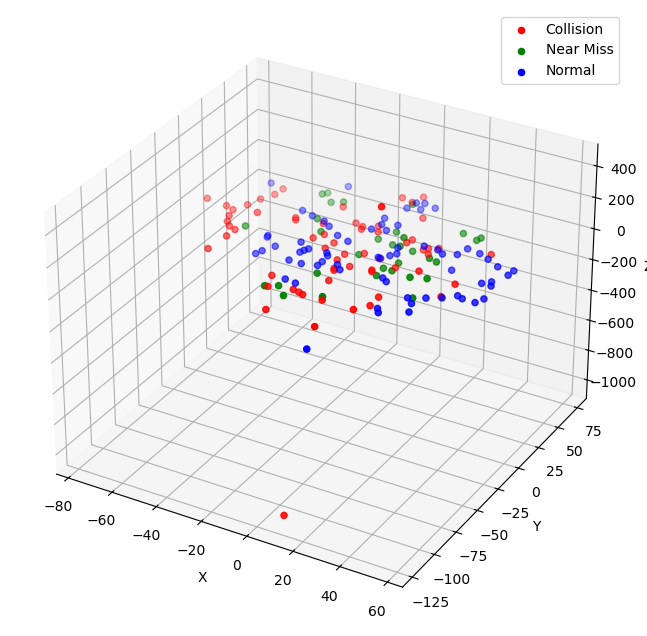

In [44]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[Y == 1, 0], X_embedded[Y == 1, 1], X_embedded[Y == 1, 2], c='r', marker='o', label='Collision')
ax.scatter(X_embedded[Y == 0, 0], X_embedded[Y == 0, 1], X_embedded[Y == 0, 2], c='g', marker='x', label='Near Miss')
ax.scatter(X_embedded[Y == -1, 0], X_embedded[Y == -1, 1], X_embedded[Y == -1, 2], c='b', marker='*', label='Normal')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.view_init(elev=30, azim=45)
plt.legend()

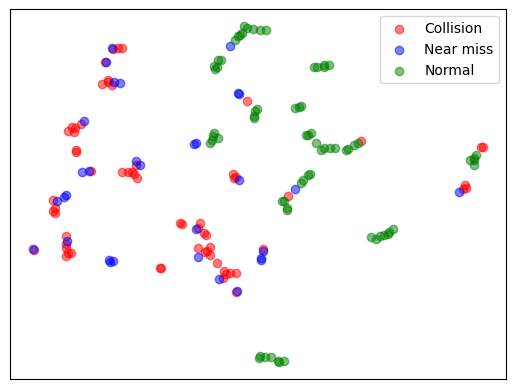

In [42]:
plt.scatter(X_embedded[Y == 1, 0], X_embedded[Y == 1, 1], c='r', label='Collision', alpha=0.5)
plt.scatter(X_embedded[Y == 0, 0], X_embedded[Y == 0, 1], c='b', label='Near miss', alpha=0.5)
plt.scatter(X_embedded[Y == -1, 0], X_embedded[Y == -1, 1], c='g', label='Normal', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.legend()

In [23]:
import plotly.graph_objects as go